In [21]:
# This notebook is for computing gradients for diffusion data using HCPMMP cortical parcellation matrix and HCP 7TDWI subjects (N=173).

# Includes the following analyses:
#     Connectivity matrix loading/checking
#     Gradients calculation
#     Gradient Variance explained
#     BF gradient weighted Cortical Projection
#     comparsion with BF stereostatic atlas
#     subregion variability

In [22]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import seaborn as sns
from scipy.spatial.distance import cdist
from brainspace.null_models.variogram import SurrogateMaps
from matplotlib.colors import ListedColormap

### Setting the path

In [23]:
# Set this to your git-repo path for running the analyses.
main_path = "."

In [24]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/Diff_gradients/"
fig_path = main_path + "/results/Diff_gradients/figures/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

### Get the connectivity matrix

In [35]:
# load npz data - you should place your data.npz file in data directory
connmap_npz = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/tpl-MBMv212/tpl-MBMv212_hemi-L_label-ZI_desc-concat_from-group_connMap.npz'

data = load(connmap_npz)
correlation = data['conn_group']

In [36]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

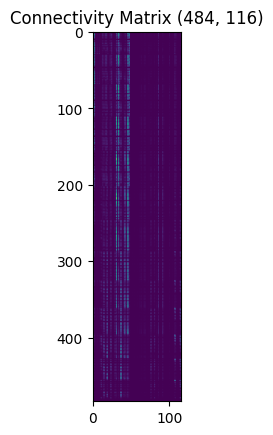

In [37]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avg)
ax.set_title('Connectivity Matrix {}'.format(corr_avg.shape))
plt.show()

### Calculate Gradient

In [38]:
n_components=100 # specify gradinet components here

In [39]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=n_components, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

GradientMaps(kernel='normalized_angle', n_components=100, random_state=0)


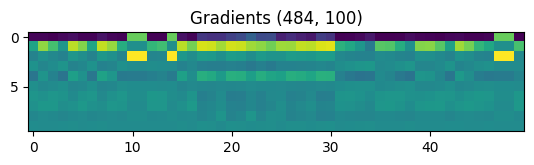

In [40]:
# Plot this gradients (up to 10 component and 50 BF voxel)
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50,:10].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [41]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + f'Diff_gradients-{n_components}_seed-BASF_1p6mm.csv', index=False)

In [42]:
# save the BF gradients (up to 6 components) as nifti files
seed_file = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/tpl-MBMv212/tpl-MBMv212_hemi-R_label-ZI_mask.nii.gz'

seed = nib.load(seed_file)
seed_vol = seed.get_fdata()
mask = data['mask']
affine = data['affine']

for gradi in range(6):

    grad_vol = np.zeros(mask.shape)
    grad_vol[mask > 0] = gm.gradients_[:,gradi]
    
    grad_nib = nib.Nifti1Image(grad_vol,affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Diff_gradient_{gradi+1}.nii.gz')

### Calculate Gradient Variance

/tmp/ipykernel_380019/4251036695.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


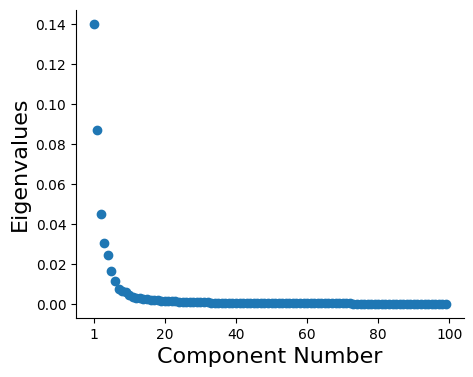

In [43]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
plt.savefig(fig_path + f'Diff_Gradient_eiganvalue_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_380019/2570041700.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


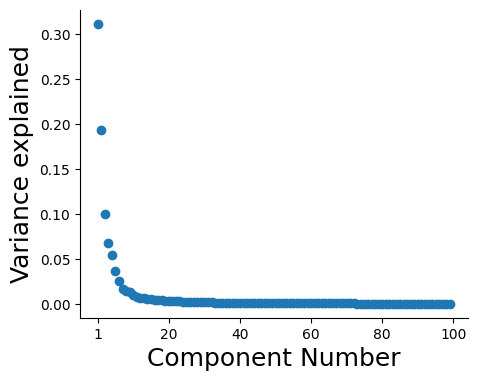

In [44]:
variance = gm.lambdas_ / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(variance.size), variance)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=18)
ax.set_ylabel('Variance explained', fontsize=18)
plt.savefig(fig_path + f'Diff_Gradient_variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Save the variance explained by each gradient components
pd.DataFrame(variance).to_csv(results_path + f'Diff_gradients_variance_gm-{n_components}.csv', index=False)

/tmp/ipykernel_380019/1288682825.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


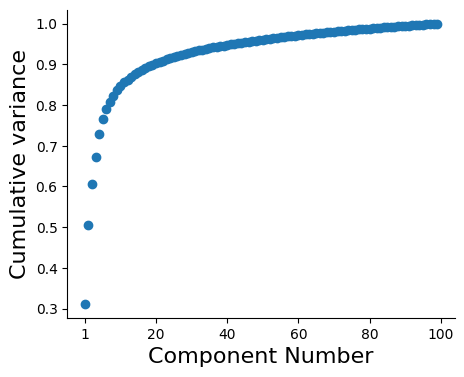

In [46]:
cum_var = np.cumsum(gm.lambdas_) / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(cum_var.size), cum_var)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Cumulative variance', fontsize=16)
plt.savefig(fig_path + f'Diff_Gradient_cumulative-variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualize Gradients

In [57]:
# set the colors for gradient visualization
colors = ['seismic','Spectral','bwr','PRGn','coolwarm','BrBG']

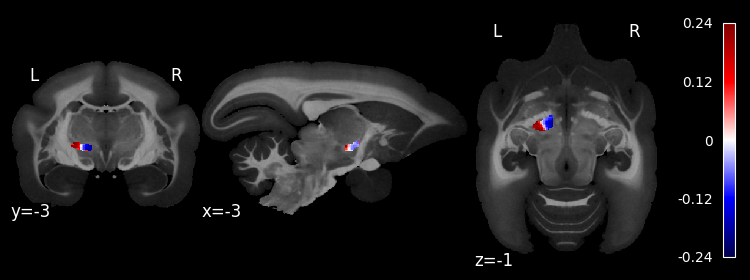

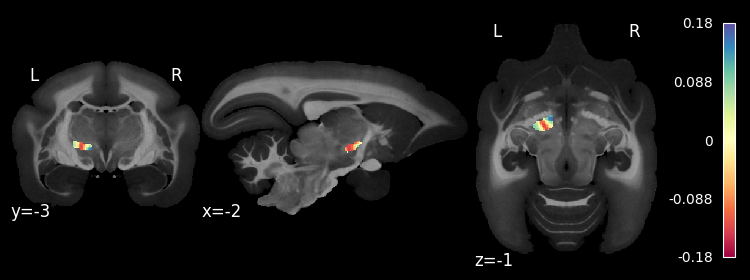

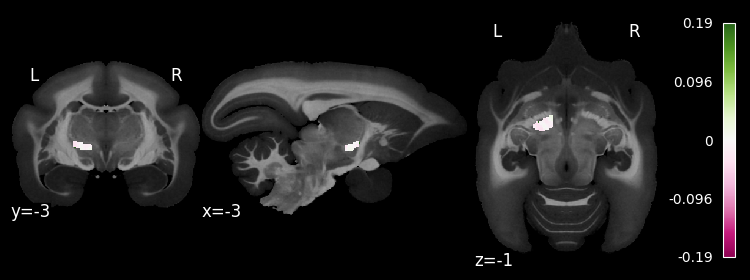

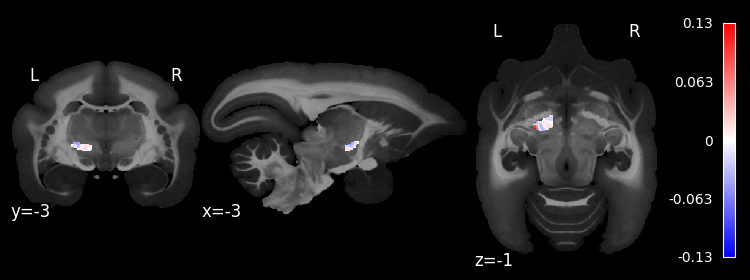

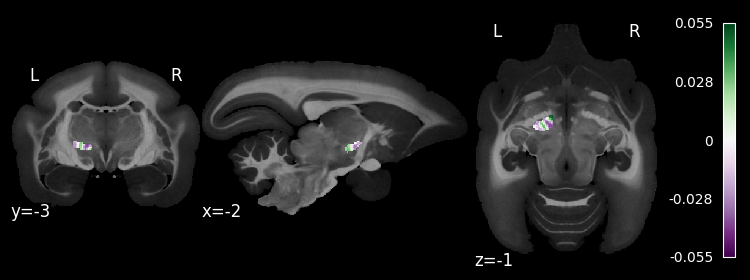

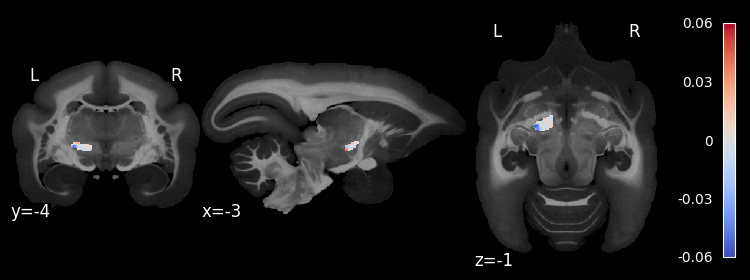

In [119]:
import nilearn

bg_img = '/home/ROBARTS/alik/graham/ext-data/marmosetbrainmapping_org/AtlasV2/Marmoset_Brain_Mapping_v2.1.2_20200131/Template_sym_MTR_80um.nii.gz'

for gradi in range(6): # up to 6 gradients
    
    grad_img = results_path + f'Diff_gradient_{gradi+1}.nii.gz'
    color = matplotlib.colormaps[colors[gradi]]
    nilearn.plotting.plot_stat_map(grad_img,bg_img,cmap=color,
                                   colorbar=True,draw_cross=False)
    plt.savefig(fig_path + f'Diff_Gradient_{gradi+1}.png',dpi=300)

### BF-gradient weighted cortical projection

In [80]:
# expand the corr_avg to match 360 cortical targets and get log-sclaed avgFC
#corr_avgFC = np.concatenate((corr_avg,corr_avg), axis=1)
corr_avgFC = corr_avg
log_corr_avgFC = np.log(corr_avg)

In [81]:
corr_avg.shape

(484, 116)

In [82]:
# save the matrices
pd.DataFrame(corr_avgFC).to_csv(results_path + f'Diff_corr-avgFC.csv', index=False)
pd.DataFrame(log_corr_avgFC).to_csv(results_path + f'Diff_log-corr-avgFC.csv', index=False)

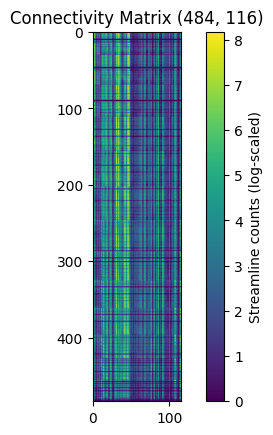

In [83]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(log_corr_avgFC)
ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
cbar = plt.colorbar(im)
cbar.set_label("Streamline counts (log-scaled)")
plt.show()

In [84]:
# compute gradient weighted cortical maps for up to 6th gradients
G_Ctx = {}
for g in range(6):
    G_Ctx[g] = np.zeros(corr_avgFC.shape)
    for i in range(len(gm.gradients_[:,g])):
        G_Ctx[g][i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,g]

In [85]:
np.savez(results_path + 'Diff_Gradient-weighted_CorticalConnectivity.npz', G1_Ctx=G_Ctx[0], G2_Ctx=G_Ctx[1], G3_Ctx=G_Ctx[2], G4_Ctx=G_Ctx[3], G5_Ctx=G_Ctx[4], G6_Ctx=G_Ctx[5])

In [87]:
Gfc = {}
for g in range(6):
    Gfc[g] = np.nanmean(G_Ctx[g], axis=0).reshape([corr_avg.shape[1],1])

In [101]:
#instead of mapping to surface (since we don't have that at the moment)
# just remap the atlas labels to the gradient-weighted values
atlas_nii = '/home/ROBARTS/alik/graham/ext-data/marmosetbrainmapping_org/AtlasV2/Marmoset_Brain_Mapping_v2.1.2_20200131/MBM_cortex_vPaxinos_80um.nii.gz'

atlas_nib = nib.load(atlas_nii)

lut_tsv = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/resources/label-paxinos_dseg.tsv'
df_lut = pd.read_csv(lut_tsv,sep='\t')


In [113]:
atlas_vol = atlas_nib.get_fdata()
gwconn={}
for g in range(2):
    gwconn_vol = np.zeros(atlas_vol.shape)
    for i,labelnum in enumerate(df_lut.label_num):
        gwconn_vol[atlas_vol == labelnum] =  Gfc[g][i]
        
    gwconn[g] = nib.Nifti1Image(gwconn_vol,
                                affine=atlas_nib.affine,
                                header=atlas_nib.header)


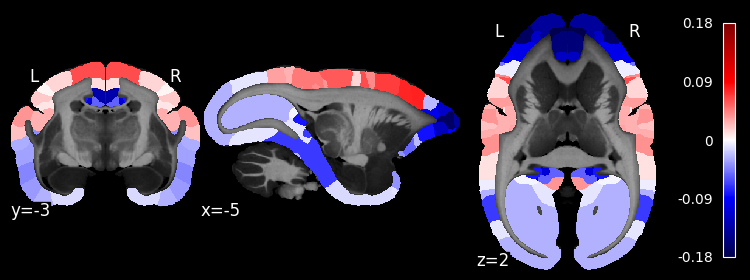

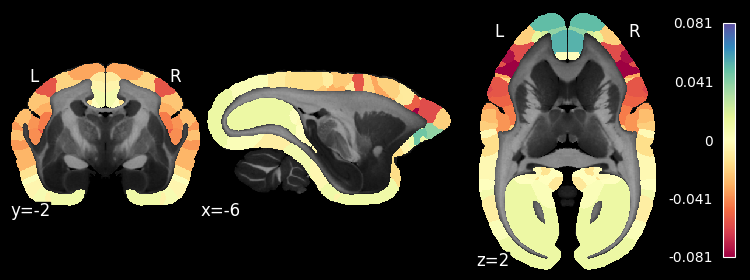

In [114]:
#visualize the grad weighted conn map
bg_img = '/home/ROBARTS/alik/graham/ext-data/marmosetbrainmapping_org/AtlasV2/Marmoset_Brain_Mapping_v2.1.2_20200131/Template_sym_MTR_80um.nii.gz'

for gradi in range(2): # up to 6 gradients
    
    color = matplotlib.colormaps[colors[gradi]]
    nilearn.plotting.plot_stat_map(gwconn[gradi],bg_img,cmap=color,
                                   colorbar=True,draw_cross=False)
    plt.savefig(fig_path + f'Diff_GradientWeightedConn_{gradi+1}.png',dpi=300)